# HW 1
**Реализация алгоритма градиентного бустинга с Laplacianloss. В качестве базового алгоритма использовать алгоритм CART c линейными признаками (задача регрессии)**

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

In [2]:
x_train, y_train = load_svmlight_file("Regression_dataset/reg.train.txt")
x_train = x_train.toarray()
print("train_x size {}, train_y size {}".format(x_train.shape, y_train.shape))

x_test, y_test = load_svmlight_file("Regression_dataset/reg.test.txt")
x_test = x_test.toarray()
print("test_x size {}, test_y size {}".format(x_test.shape, y_test.shape))

train_x size (7200, 245), train_y size (7200,)
test_x size (10050, 245), test_y size (10050,)


### Boosting sklearn

In [4]:
N_ESTIMATORS = 100

base_model = GradientBoostingRegressor(loss='lad', n_estimators=N_ESTIMATORS, max_depth=3)
base_model.fit(x_train, y_train)
mse = mean_squared_error(y_test, base_model.predict(x_test))
print("sklearn boosting MSE: %.4f" % mse)

sklearn boosting MSE: 0.9377


### Custom tree

In [10]:
%%time
class MyDecisionTreeRegressor:
    NON_LEAF_TYPE = 'NON_LEAF'
    LEAF_TYPE = 'LEAF'

    def __init__(self,
                 min_samples_split=3,
                 max_depth=3,
                 min_impurity_split=0.1,
                 random_state=None,
                 best_tail=3):

        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_variance_split = min_impurity_split
        self.best_tail = best_tail

    @staticmethod
    def sort_samples_(x, y):
        sorted_idx = x.argsort(axis=0)
        return x[sorted_idx], y[sorted_idx]

    @staticmethod
    def divide_items_(x, y, feature_pair, threshold):
        left_mask = (x[:, feature_pair[0]] + x[:, feature_pair[1]]) > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    @staticmethod
    def get_variance_(y):
        N = y.shape[1]
        y_sq = y ** 2

        sum_sq_left = (y_sq[:, :N - 1]).cumsum(1)
        sum_sq_right = y_sq.sum(1)[:, None] - sum_sq_left
        mean_sq_left = sum_sq_left / np.arange(1, N)
        mean_sq_right = sum_sq_right / (N - np.arange(1, N))

        sum_left = (y[:, :N - 1]).cumsum(1)
        sum_right = y.sum(1)[:, None] - sum_left
        mean_left = sum_left / np.arange(1, N)
        mean_right = sum_right / (N - np.arange(1, N))

        std_left = mean_sq_left - mean_left ** 2
        std_right = mean_sq_right - mean_right ** 2
        variance = std_left * (np.arange(1, N) / N) + std_right * ((N - np.arange(1, N)) / N)
        return variance

    @staticmethod
    def get_border_ind_(x):
        difference = np.diff(x, axis=0).T
        ind = np.argwhere(np.abs(difference) > 1e-10)
        border_ind = []
        for i in range(x.shape[1]):
            ind_in_column = ind[ind[:, 0] == i][:, 1]
            if ind_in_column.shape[0] == 0:
                ind_in_column = np.array([float('+inf')])
            border_ind.append(ind_in_column)
        return border_ind

    def find_threshold_array_(self, x, y):
        sorted_ids = np.argsort(x, axis=0)
        sorted_x, sorted_y_t = x[sorted_ids, np.arange(x.shape[1])], y[sorted_ids].T
        border_ind = self.get_border_ind_(sorted_x)
        variance = self.get_variance_(sorted_y_t)
        min_variance_ind = []
        min_variance_no_ind = []

        for feature_ind, border_ind in enumerate(border_ind):
            if border_ind[0] == float('+inf'):
                min_variance_ind.append(0)
                min_variance_no_ind.append(len(min_variance_ind) - 1)
                continue
            idx = np.argmin(variance[feature_ind, border_ind])
            min_variance_ind.append(border_ind[idx])

        min_variance_ind = np.array(min_variance_ind)
        min_variance_no_ind = np.array(min_variance_no_ind)
        min_variance = variance[np.arange(variance.shape[0]), min_variance_ind.ravel()]

        if min_variance_no_ind.shape[0] > 0:
            min_variance[min_variance_no_ind] = float('+inf')

        best_split_right_ind = min_variance_ind + 1
        min_variance[best_split_right_ind <= self.min_samples_split] = np.float('+inf')
        min_variance[best_split_right_ind >= sorted_y_t.shape[1] - self.min_samples_split] = np.float('+inf')
        best_threshold = (sorted_x[min_variance_ind, np.arange(sorted_x.shape[1])]
                          + sorted_x[best_split_right_ind, np.arange(sorted_x.shape[1])]) / 2
        return min_variance, best_threshold

    def fit(self, x, y):
        assert x.ndim == 2
        assert y.ndim == 1
        self.best_tail = min(self.best_tail, x.shape[1])
        self.fit_node_(x, y, 0, 0)
        return self

    def is_leaf_(self, x, y, depth):
        return x.shape[0] < 2 * self.min_samples_split + 2 or np.unique(y).shape[0] == 1 or \
               self.max_depth is not None and depth >= self.max_depth or \
               self.min_variance_split is not None and np.mean((y - y.mean()) ** 2) < self.min_variance_split

    def set_leaf_(self, x, y, node_id):
        mean_value = y.mean()
        self.tree[node_id] = {'type': self.LEAF_TYPE,
                              'value': mean_value}

    def fit_node_(self, x, y, node_id, depth):
        if self.is_leaf_(x, y, depth):
            self.set_leaf_(x, y, node_id)
            return

        variance, thresholds = self.find_threshold_array_(x, y)

        first_range_ids = np.argpartition(variance, self.best_tail)[:self.best_tail]
        tail_x = x[:, first_range_ids]
        new_x = np.empty([tail_x.shape[0], tail_x.shape[1] * (tail_x.shape[1] + 1) // 2])
        feature_mask = []
        border = 0
        for i in range(tail_x.shape[1]):
            new_x[:, border: border + (tail_x.shape[1] - i)] = \
                np.repeat(tail_x[:, i, None], tail_x.shape[1] - i, axis=1) + tail_x[:, i: tail_x.shape[1]]
            border += tail_x.shape[1] - i
            feature_mask += [(i, j) for j in range((tail_x.shape[1] - i))]

        variance, thresholds = self.find_threshold_array_(new_x, y)
        best_feature_id = np.argmin(variance)
        # print(np.array(feature_mask[best_feature_id.item()]))
        feature_pair = first_range_ids[np.array(feature_mask[best_feature_id.item()])]
        best_variance = variance[best_feature_id]
        best_threshold = thresholds[best_feature_id]

        if best_variance == float('+inf'):
            self.set_leaf_(x, y, node_id)
            return

        left_x, right_x, left_y, right_y = self.divide_items_(x, y, feature_pair, best_threshold)

        if left_x.shape[0] == 0 or right_x.shape[0] == 0:
            self.set_leaf_(x, y, node_id)
            return

        self.tree[node_id] = {'type': self.NON_LEAF_TYPE,
                              'feature_pair': feature_pair,
                              'threshold': best_threshold}

        self.fit_node_(left_x, left_y, 2 * node_id + 1, depth + 1)
        self.fit_node_(right_x, right_y, 2 * node_id + 2, depth + 1)
        return

    def predict(self, x):
        assert x.ndim == 2
        return np.array([self.predict_value_(x, 0) for x in x])

    def predict_value_(self, x, node_id):
        node = self.tree[node_id]
        if node['type'] == self.__class__.NON_LEAF_TYPE:
            feature_pair, threshold = node['feature_pair'], node['threshold']
            if x[feature_pair[0]] + x[feature_pair[1]] > threshold:
                return self.predict_value_(x, 2 * node_id + 1)
            else:
                return self.predict_value_(x, 2 * node_id + 2)
        else:
            return node['value']
        
tree = MyDecisionTreeRegressor()
tree.fit(x_train, y_train)
mse = mean_squared_error(y_test, tree.predict(x_test))
print("my tree MSE: %.4f" % mse)

my tree MSE: 0.8690
CPU times: user 63.3 ms, sys: 92 µs, total: 63.4 ms
Wall time: 62.6 ms


### Custom gradient boosting

In [11]:
%%time

class MyGradientBoostingRegressor:
    def __init__(self, learning_rate=0.95,
                 n_estimators=100,
                 max_depth=3,
                 random_state=None,
                 verbose=False,
                 base_estimator=DecisionTreeRegressor):

        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.verbose = verbose
        self.base_estimator = base_estimator

        self.train_score_ = []
        self.estimators = [None] * self.n_estimators

    @staticmethod
    def loss_(y_pred, y_true):
        return np.abs(y_pred - y_true).mean()

    @staticmethod
    def negative_gradient_(y_pred, y_true):
        return np.sign(y_true - y_pred)

    @staticmethod
    def bi_(array, sample_weight, percentile=50):
        sorted_idx = np.argsort(array)
        weight_cdf = np.cumsum(sample_weight[sorted_idx])
        percentile_idx = np.searchsorted(weight_cdf, (percentile / 100.) * weight_cdf[-1])
        percentile_idx = np.clip(percentile_idx, 0, len(sorted_idx) - 1)
        return array[sorted_idx[percentile_idx]]


    def fit(self, x, y):
        self.weight = np.zeros(self.n_estimators, dtype=float)
        self.estimators[0] = self.base_estimator(max_depth=self.max_depth).fit(x, y)
        self.weight[0] = 1.0

        prediction = self.estimators[0].predict(x)

        if self.verbose:
            print('estimator: {}, loss: {:.4f}, depth: {}'.
                  format(0, self.loss_(y_true=y, y_pred=prediction), None))
        self.train_score_.append(self.loss_(y_true=y, y_pred=prediction))

        for i in range(1, self.n_estimators):

            gi = self.negative_gradient_(prediction, y)
            self.estimators[i] = self.base_estimator(max_depth=self.max_depth).fit(x, gi)

            ai_predict = self.estimators[i].predict(x)
            with np.errstate(divide='ignore'):
                self.weight[i] = self.learning_rate * self.bi_((y - prediction)/ai_predict, np.abs(ai_predict))

            prediction += self.weight[i] * ai_predict

            if self.verbose:
                print('estimator: {}, loss: {:.4f}, depth: {}'.
                      format(i, self.loss_(y_true=y, y_pred=prediction), None))
            self.train_score_.append(self.loss_(y_true=y, y_pred=prediction))
        return self

    def predict(self, x, y_true=None):
        prediction = np.zeros(x.shape[0])
        for i, model in enumerate(self.estimators):  # check
            prediction += self.weight[i] * model.predict(x)
            if self.verbose and y_true is not None:
                print('estimators:{}  loss:{:.4f}'.format(i + 1, self.loss_(y_true=y_true, y_pred=prediction)))
        return prediction

    def staged_predict(self, x, y_true):
        prediction = np.zeros(x.shape[0])
        train_score = []
        for i, model in enumerate(self.estimators):
            prediction += self.weight[i] * model.predict(x)
            if self.verbose and y_true is not None:
                print('estimators:{}  loss:{:.4f}'.format(i + 1, self.loss_(y_true=y_true, y_pred=prediction)))
            train_score.append(self.loss_(y_true=y_true, y_pred=prediction))
        return prediction, train_score

my_model = MyGradientBoostingRegressor(learning_rate=0.95, n_estimators=N_ESTIMATORS, max_depth=3, 
                                       base_estimator=MyDecisionTreeRegressor)
my_model.fit(x_train, y_train)
mse = mean_squared_error(y_test, my_model.predict(x_test))
print("my boosting MSE: %.4f" % mse)

my boosting MSE: 0.8792


### Show graph

Text(0, 0.5, 'Deviance')

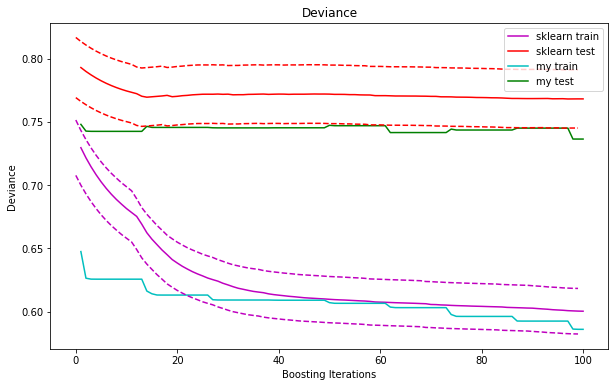

In [12]:
base_test_score = np.zeros((N_ESTIMATORS,), dtype=np.float64)
for i, y_pred in enumerate(base_model.staged_predict(x_test)):
    base_test_score[i] = base_model.loss_(y_test, y_pred)


my_model.verbose = False
_, my_test_score = my_model.staged_predict(x_test, y_test)
plt.figure(figsize=(10, 6))
plt.title('Deviance')
plt.plot(np.arange(N_ESTIMATORS) + 1, base_model.train_score_, 'm-', label='sklearn train')
plt.plot(np.arange(N_ESTIMATORS) + 1, base_test_score, 'r-', label='sklearn test')
plt.plot(np.arange(N_ESTIMATORS) + 1, my_model.train_score_[:N_ESTIMATORS], 'c-', label='my train')
plt.plot(np.arange(N_ESTIMATORS) + 1, my_test_score[:N_ESTIMATORS], 'g-', label='my test')

plt.plot([x * 1.03 for x in base_model.train_score_], 'm-', linestyle='--')
plt.plot([x * 0.97 for x in base_model.train_score_], 'm-', linestyle='--')
plt.plot([x * 1.03 for x in base_test_score], 'r-', linestyle='--')
plt.plot([x * 0.97 for x in base_test_score], 'r-', linestyle='--')

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

DONE